In [1]:
import torch
from torch.optim import Adam

import pickle
import soundfile as sf
import IPython.display as ipd

from constants import *
from train import train_model
from early_stopper import EarlyStopper

from phase_loss import PhaseLoss
from magnitude_loss import MagnitudeLoss

from polar_dataset import build_data_loaders
from disk_utils import save_model, load_model
from plotter import plot_loss, plot_heatmaps, plot_waves
from predict import predict_polar, get_phases, make_wav

from models.model_2 import Model_2
from models.model_18 import Model_18
from models.model_19 import Model_19

In [2]:
USE_GPU = True

num_epochs = 250
test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not USE_GPU:
    device = torch.device("cpu")
    num_epochs = 1

In [3]:
with open("dataset/features/min_max.pkl", "rb") as handle:
    min_max = pickle.load(handle)

# model = Model_18()
model = Model_2(1, 1, 32)

part = "magnitude"
train_data_loader, test_data_loader = build_data_loaders(
    min_max, part=part, test_size=test_size)

criterion = MagnitudeLoss(
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part]
)
optimizer = Adam(model.parameters(), lr=3e-4)
es = EarlyStopper(7, 3e-6)

In [4]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    device,
    train_data_loader, test_data_loader,
    es,
    num_epochs=num_epochs
)

Starting training...


E: 001/250	 T: 1351.584660	 V: 410.321943
E: 002/250	 T: 225.043885	 V: 121.912541
E: 003/250	 T: 83.757575	 V: 63.622537
E: 004/250	 T: 42.834858	 V: 31.802379
E: 005/250	 T: 25.970166	 V: 28.992270
E: 006/250	 T: 17.466170	 V: 18.935652
E: 007/250	 T: 12.595453	 V: 17.116548
E: 008/250	 T: 12.574553	 V: 15.502986
E: 009/250	 T: 8.091847	 V: 14.505270
E: 010/250	 T: 6.551297	 V: 11.935927
E: 011/250	 T: 5.539751	 V: 12.265385
E: 012/250	 T: 4.770454	 V: 11.618918
E: 013/250	 T: 4.561623	 V: 9.439916
E: 014/250	 T: 3.730691	 V: 10.045195
E: 015/250	 T: 3.277945	 V: 9.479831
E: 016/250	 T: 2.859303	 V: 9.477733
E: 017/250	 T: 2.480731	 V: 9.467984
E: 018/250	 T: 2.162443	 V: 10.193443
E: 019/250	 T: 1.862807	 V: 9.415343
E: 020/250	 T: 1.621587	 V: 9.894881
E: 021/250	 T: 1.770496	 V: 8.654628
E: 022/250	 T: 1.185830	 V: 8.568373
E: 023/250	 T: 1.007657	 V: 8.192336
E: 024/250	 T: 0.889164	 V: 9.556534
E: 025/250	 T: 0.772198	 V: 8.307691
E: 026/250	 T: 0.676390	 V: 9.197562
E: 027/250	

In [5]:
model.to(torch.device("cpu"))

Model_2(
  (encoder1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sigmoid()
  )
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sigmoid()
  )
  (encoder3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sigmoid()
  )
  (encoder4): Sequential(
    (0): Conv2

In [6]:
del model
torch.cuda.empty_cache()

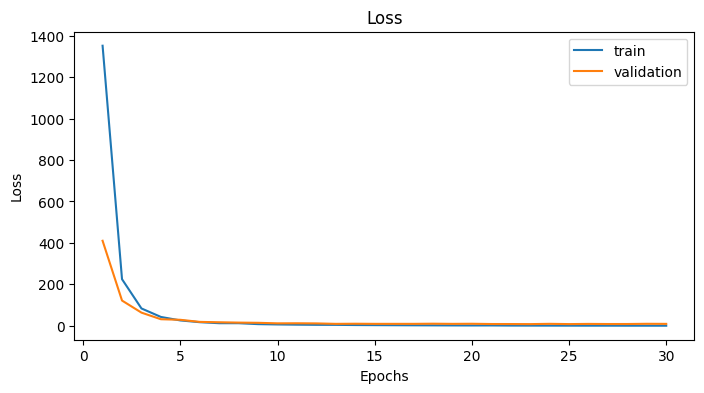

In [6]:
plot_loss(history, "Loss", start=0)

In [15]:
model = load_model("model_19_mag")

In [7]:
pred_limit = 32
predictions, targets = predict_polar(
    model,
    test_data_loader,
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part],
    limit=pred_limit)

08_Gtr_Gs_3/chunk_0, 08_Gtr_Gs_3/chunk_1, 08_Gtr_Gs_3/chunk_2, 08_Gtr_Gs_3/chunk_3
08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3


--------------------------------------------------
08_Gtr_Gs_3/chunk_4, 08_Gtr_Gs_3/chunk_5, 08_Gtr_Gs_3/chunk_6, 08_Gtr_Gs_3/chunk_7
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Gtr_Gs_3/chunk_8, 08_Gtr_Gs_3/chunk_9, 08_Gtr_Gs_3/chunk_10, 08_Gtr_Gs_3/chunk_11
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------
08_Gtr_Gs_3/chunk_12, 08_Gtr_Gs_3/chunk_13, 08_Gtr_Gs_3/chunk_14, 08_Gtr_Gs_3/chunk_15
08_Ney_Gs_3/chunk_12, 08_Ney_Gs_3/chunk_13, 08_Ney_Gs_3/chunk_14, 08_Ney_Gs_3/chunk_15
--------------------------------------------------
08_Gtr_Gs_3/chunk_16, 08_Gtr_Gs_3/chunk_17, 08_Gtr_Gs_3/chunk_18, 08_Gtr_Gs_3/chunk_19
08_Ney_Gs_3/chunk_16, 08_Ney_Gs_3/chunk_17, 08_Ney_Gs_3/chunk_18, 08_Ney_Gs_3/chunk_19
--------------------------------------------------
08_Gtr_Gs_3/chunk_20, 08_Gtr_Gs_3/chunk_21, 08_Gtr_Gs_3/chunk

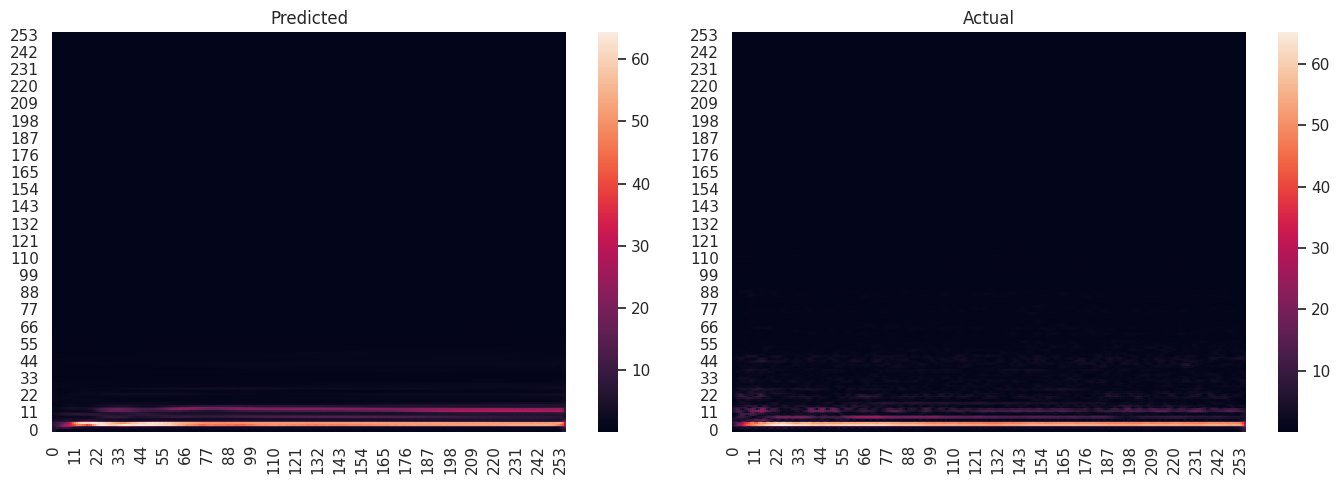

In [8]:
plot_heatmaps(predictions[0], targets[0])

In [9]:
_, test_data_loader_phase = build_data_loaders(
    min_max, part="phase", test_size=test_size)
phases = get_phases(test_data_loader_phase,
                    instrument="ney",
                    limit=pred_limit)

08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3
--------------------------------------------------
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------
08_Ney_Gs_3/chunk_12, 08_Ney_Gs_3/chunk_13, 08_Ney_Gs_3/chunk_14, 08_Ney_Gs_3/chunk_15
--------------------------------------------------
08_Ney_Gs_3/chunk_16, 08_Ney_Gs_3/chunk_17, 08_Ney_Gs_3/chunk_18, 08_Ney_Gs_3/chunk_19
--------------------------------------------------
08_Ney_Gs_3/chunk_20, 08_Ney_Gs_3/chunk_21, 08_Ney_Gs_3/chunk_22, 08_Ney_Gs_3/chunk_23
--------------------------------------------------
08_Ney_Gs_3/chunk_24, 08_Ney_Gs_3/chunk_25, 08_Ney_Gs_3/chunk_26, 08_Ney_Gs_3/chunk_27
--------------------------------------------------
08_Ney_Gs_3/chunk_28, 08_Ney_Gs_3/chunk_29, 

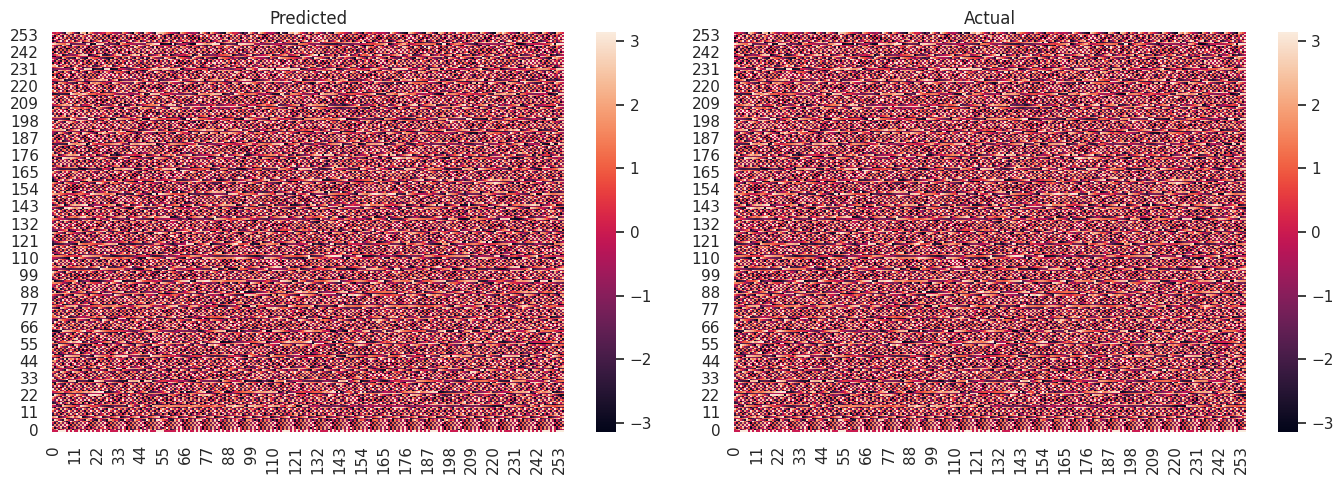

In [10]:
plot_heatmaps(phases[0], phases[0])

48064 48064


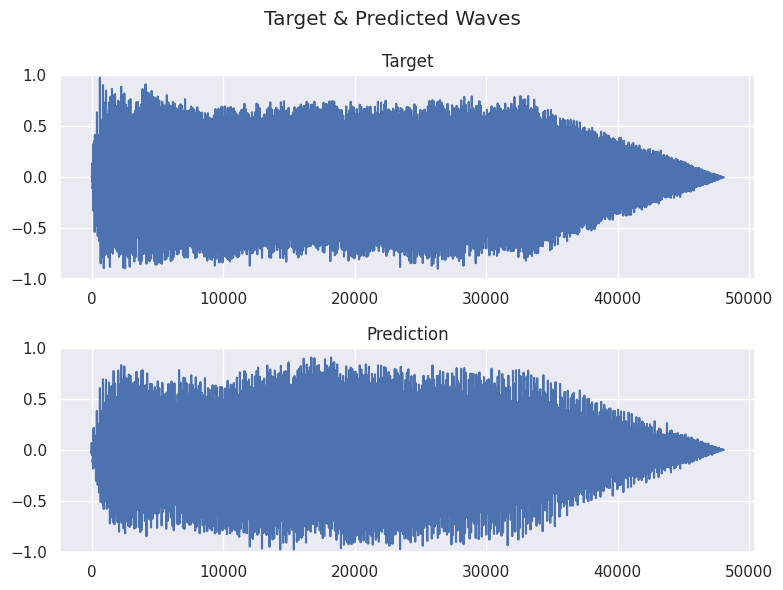

In [11]:
wave_prediction = make_wav(predictions, phases)
wave_target = make_wav(targets, phases)
print(len(wave_prediction), len(wave_target))
plot_waves(wave_target, wave_prediction)

In [21]:
ipd.Audio(wave_target, rate=SR)

In [22]:
ipd.Audio(wave_prediction, rate=SR)

In [12]:
sf.write("z_target.wav", wave_target, SR, format="wav")
sf.write("z_prediction.wav", wave_prediction, SR, format="wav")

In [13]:
save_model(model, "model_2_mag_1b")